**Investigating Causes and Impacts of Air Pollution in Poland**

**Objective 3: Investigate the annual concentration of PM 2.5 and Death caused by Respiratory Diseases in each Voivodeship in Poland**

1. Acquire the data of annual concentration of PM 2.5 and the rate of death caused by respiratory diseases and in each Voivodeship in Poland from 2013 until 2020.  
2. Preprocess the data
3. Analyze the correlation between the annual air pollution PM 2.5 and death caused by respiratory disease using linear regression with python.
4. Create scatter plot that show the correlation between the annual concentration of PM 2.5 and the number of death caused by respiratory diseases in all Voivodeship.
5. Export the coefficient of correlation of between he annual concentration of PM 2.5 and the number of death caused by respiratory diseases per Voivodeship as an output file.

**Acquire the data**

Source of data:


*   Annual concentration of PM 2.5 : https://powietrze.gios.gov.pl/pjp/archives . Data downloaded at 21 January 2024.
*   Rate of death caused by respiratory diseases:https://ec.europa.eu/eurostat/web/main/data/database . Data downloaded at 21 January 2024.

**Preprocess the data**

The raw data of the annual concentration of PM 2.5 is written in Polish and has 13 columns. We only needed three columns for our analysis, so we filtered the data and translated the header into English.

After data filtering, we calculated the annual average concentration of PM 2.5 for each voivodeship and then put the result in the column 'avg_pm25'. The next step is to export the result as a new data frame.








In [88]:
# Structure the data of PM 2.5 concentration and death caused by respiratory diseases
import pandas as pd
import openpyxl
from openpyxl import load_workbook
from collections import defaultdict

#Open the excel file
file_path = 'PM 2.5_voivodeship.xlsx'
wb = openpyxl.load_workbook(file_path)
sheet = wb.active

# Process the data
processed_data = {}
for row in range(2, sheet.max_row + 1):  #Row 1 contains headers
    year = sheet.cell(row=row, column=1).value
    voivodeship = sheet.cell(row=row, column=2).value
    avg_time = sheet.cell(row=row, column=7).value
    avg_pm25 = sheet.cell(row=row, column=8).value

    if avg_time == '24g':
        if year not in processed_data:
            processed_data[year] = {'Year': year, 'data': {voivodeship: [avg_pm25]}}
        else:
            if voivodeship not in processed_data[year]['data']:
                processed_data[year]['data'][voivodeship] = [avg_pm25]
            else:
                processed_data[year]['data'][voivodeship].append(avg_pm25)

# Calculate the average of avg_pm25 for each year and voivodeship
averaged_data = {}
for year, data in processed_data.items():
    for voivodeship, pm25_data in data['data'].items():
        avg_pm25 = sum(pm25_data) / len(pm25_data)
        if year not in averaged_data:
            averaged_data[year] = {'Year': year, 'data': {voivodeship: avg_pm25}}
        else:
            if voivodeship not in averaged_data[year]['data']:
                averaged_data[year]['data'][voivodeship] = avg_pm25
            else:
                averaged_data[year]['data'][voivodeship] = (averaged_data[year]['data'][voivodeship] + avg_pm25) / 2

columns = ['Year', 'voivodeship', 'avg_pm25']
avg_list = []

# Iterate through the 'averaged_data' dictionary and append each entry as a new row to the data frame
for year, data in averaged_data.items():
    for voivodeship, avg_pm25 in data['data'].items():
        df_tempt = pd.DataFrame({'Year': [year], 'Voivodeship': [voivodeship], 'Avg_pm25': [avg_pm25]})
        avg_list.append(df_tempt)

avg_df = pd.concat(avg_list, ignore_index=True)

**Analyze the correlation between the annual air pollution PM 2.5 and death caused by respiratory disease using linear regression with python**


**1. Load libraries**

In [89]:
#Linear Regression

# importing modules and packages
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

**2. Import and merge the relevant data**


We merged dataframe of annual concentration of PM 2.5 and the data from the death caused by respiratory diseased document. In the process of merging data, the key column is 'Year' and 'Voivodeship'. We named the merged data as 'merged_data'.

In [90]:
# importing data
doc1 = avg_df
doc2 = pd.read_excel('Diseases of the respiratory system.xlsx', header=0)

merged_data = pd.merge(doc1,doc2, on=['Year', 'Voivodeship'])
print(merged_data)

     Year          Voivodeship   Avg_pm25  Respiratory_Diseases
0    2013         dolnośląskie  23.911116                 57.44
1    2013   kujawsko-pomorskie  17.111660                 58.44
2    2013            lubelskie  21.405968                 56.83
3    2013             lubuskie  19.610427                 54.78
4    2013              łódzkie  27.831758                 81.36
..    ...                  ...        ...                   ...
123  2020              śląskie  21.538059                 55.30
124  2020       świętokrzyskie  18.670982                 67.14
125  2020  warmińsko-mazurskie  12.391373                 88.71
126  2020        wielkopolskie  18.613556                 64.94
127  2020   zachodniopomorskie  11.568292                 73.45

[128 rows x 4 columns]


**3. Choose the variable and calculate the correlation for each voivodeship**

We choose an annual concentration of PM 2.5 as the Y variable and the rate of death
caused by respiratory diseases as the X variable. Then, we make a loop to calculate the correlation of X and Y for each voivodeship using pandas.

The result of the calculation is stored in the data frame called 'result_df'.

In [91]:
# Extract the factors X and Y
Y = merged_data['Avg_pm25']
X = merged_data['Respiratory_Diseases']

# Initialize an empty list to store the results
results = []

# Iterate through each unique value in the 'Voivodeship' column
for voivodeship in merged_data['Voivodeship'].unique():
    # Filter the DataFrame to only include rows with the current value in the 'Voivodeship' column
    voivodeship_data = merged_data[merged_data['Voivodeship'] == voivodeship]

    # Calculate the correlation coefficient between X and Y for the filtered DataFrame
    corr = voivodeship_data['Respiratory_Diseases'].corr(voivodeship_data['Avg_pm25'])

    # Fit a regression model using OLS (ordinary least squares) on the filtered DataFrame
    result = smf.ols(formula='Respiratory_Diseases ~ Avg_pm25', data=voivodeship_data).fit()

    # Add the correlation coefficient and regression summary to the results list
    results.append((voivodeship, corr))

# Create a DataFrame from the results list
results_df = pd.DataFrame(results, columns=['Voivodeship','Correlation'])

**4. Create scatter plot that show the correlation between the annual concentration of PM 2.5 and the number of death caused by respiratory diseases in all Voivodeship.**

In this visualization, we differentiate each voivodeship by colours and put the color information of each voivodeship in the legend on the top right of the figure. To give more insight into the graph, we also put a straight line on the Y-axis value five as the WHO guidelines for the annual average maximum concentration of PM 2.5 is five µg/m3.

We gave a grey colour on the area above the Y-axis value 5 to show how many voivodeships have an annual average concentration of PM 2.5 that exceeds the WHO guidelines.

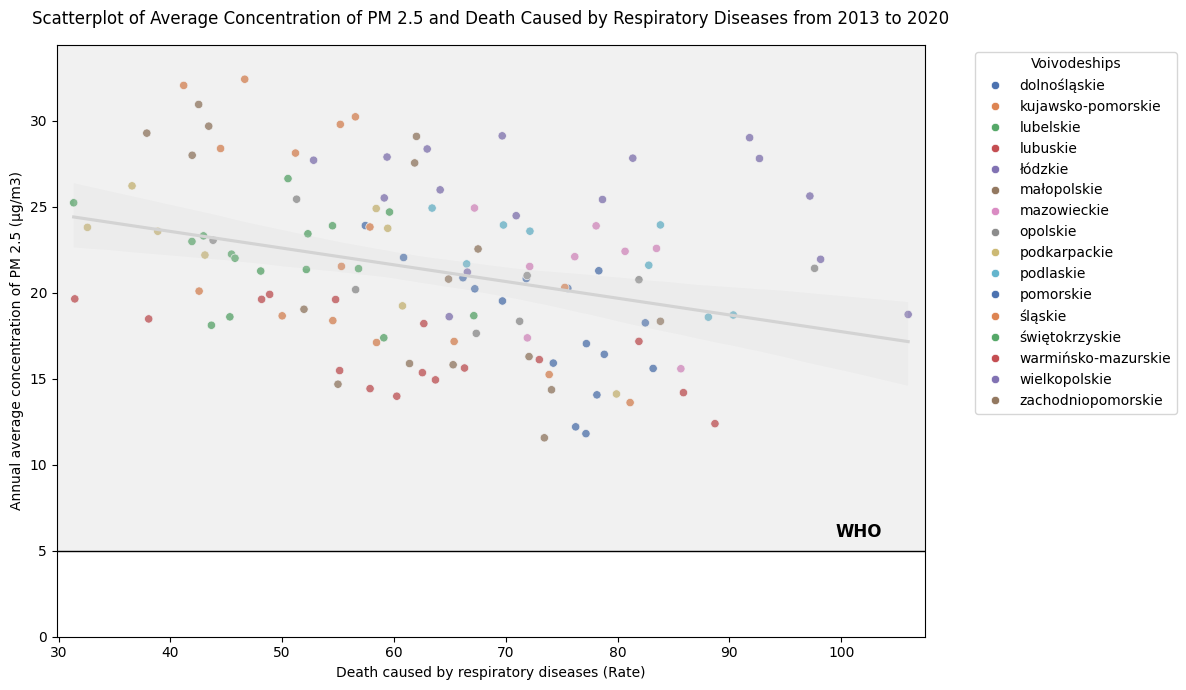

In [92]:
# Get the maximum value of the y data
max_value = merged_data['Avg_pm25'].max()

# Visualize the relationship between X and Y with regression lines for each Voivodeship
plt.figure(figsize=(12, 7))  # Adjust the figure size

# Scatter plot
sns.scatterplot(data=merged_data, y='Avg_pm25', x='Respiratory_Diseases', hue='Voivodeship', palette='deep')

# Regression line
sns.regplot(data=merged_data, y='Avg_pm25', x='Respiratory_Diseases', scatter=False, color='lightgrey')

# Set axis limits
plt.xlim(left=(merged_data['Respiratory_Diseases'].min())-1.5, right=(merged_data['Respiratory_Diseases'].max())+1.5)
plt.ylim(bottom=0, top=max_value + 2)

# Labels and title
plt.ylabel('Annual average concentration of PM 2.5 (µg/m3)')
plt.xlabel('Death caused by respiratory diseases (Rate)')
plt.title('Scatterplot of Average Concentration of PM 2.5 and Death Caused by Respiratory Diseases from 2013 to 2020', pad=15)

# Legend
legend = plt.legend(title='Voivodeships')
legend.set_bbox_to_anchor((1.05, 1))  # Move the legend outside the plot area

# Add a horizontal line at y = 5
plt.axhline(y=5, color='black', linestyle='-', linewidth=1)

# Add the word "WHO" at the top of the line
plt.text(0.7, 0.22, 'WHO', transform=plt.gcf().transFigure, fontsize=12, fontweight='bold', color='black', verticalalignment='bottom')

# Add light grey color for the area above the line on y-axis value = 5
plt.axhspan(5, max_value + 2, color='lightgrey', alpha=0.3)

plt.tight_layout()

plt.show()

**Insight from the graph**

The graph above shows a weak relationship between the annual average of PM 2.5 concentration and death caused by respiratory disease. The direction is slightly declining, which can be interpreted as the negative association between variables. The form shows a possibility of a linear relationship, which means that one variable increases at the same rate as the other variables change by one unit   (Mindrila & Balentyne, n.d.).

The grey area also shows that all voivodeships have been exposed to dangerous concentration levels of PM 2.5 at all times between 2013 and 2020. Further research is needed in order to find any confounding variables that might be included in the analysis to identify how significant air pollution contributed to the rate of death caused by respiratory diseases compared to the other confounding variables. Some confounding variables that could be consider are smoking and occupational risks as they are included as the causes of Cronic Respiratory Disease (CRDs) beside air pollution (Institute for Health Metric and Evaluation, 2023).

Furthermore, the duration of the exposure to the PM 2.5 could also be consider as one of the variables in the analyzation as the highest rates of death caused by respiratory diseases in Poland from 2018-2020 is happened with people age 65 years old or more (Eurostat, 2023).

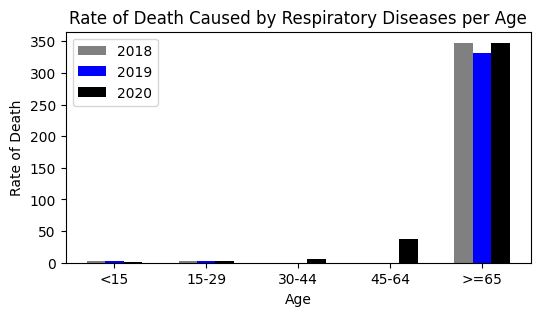

In [96]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('Death caused by respiratory diseases by age.xlsx', skiprows=1, usecols='A:D')

# Set the X and Y data columns
df.columns = ['Age', '2018', '2019', '2020']

# Create a new figure
fig, ax = plt.subplots(figsize=(6, 3))

# Plot all three categories on the same axes with different colors
ax.bar(df.index - 0.2, df['2018'], width=0.2, label='2018', color='grey')
ax.bar(df.index, df['2019'], width=0.2, label='2019', color='blue')
ax.bar(df.index + 0.2, df['2020'], width=0.2, label='2020', color='black')

# Set labels and title
ax.set_title('Rate of Death Caused by Respiratory Diseases per Age')
ax.set_xlabel('Age')
ax.set_ylabel('Rate of Death')

# Set x-axis ticks and labels
ax.set_xticks(df.index)
ax.set_xticklabels(df['Age'])

# Display legend
ax.legend()

# Show the plot
plt.show()



**5. Export the coefficient of correlation of between the annual concentration of PM 2.5 and the number of death caused by respiratory diseases per Voivodeship as an output file**

The final step is printing and exporting the coefficient of correlation per voivodeship as an excel file to gain better understanding of the relationship between the annual concentration of PM 2.5 and the number of death caused by respiratory diseases.

In [94]:
# Print the DataFrame
print(results_df)

# Save the DataFrame to a CSV file
results_df.to_excel('output_respiratory.xlsx', index=False)

            Voivodeship  Correlation
0          dolnośląskie    -0.770073
1    kujawsko-pomorskie    -0.617880
2             lubelskie     0.178606
3              lubuskie    -0.541824
4               łódzkie    -0.702776
5           małopolskie    -0.726877
6           mazowieckie    -0.367647
7              opolskie    -0.372317
8          podkarpackie    -0.766783
9             podlaskie    -0.732648
10            pomorskie    -0.413624
11              śląskie    -0.587284
12       świętokrzyskie    -0.538815
13  warmińsko-mazurskie    -0.386861
14        wielkopolskie    -0.520024
15   zachodniopomorskie    -0.159537


**Insight from the coefficient correlation**

Among the voivodeships that have a negative coefficient, two voivodeships have none or very weak strength, four voivodeships have weak strength, five voivodeships have moderate strength, and five voivodeships have strong strength.

Overall, we conclude that the relationship is negative relationship with weak or moderate strength.